In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from oct_dataset import OCTDataset
import torch.nn as nn
from lossfunctions import DiceLoss, DiceBCELoss

In [ ]:
import numpy as np
import os
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from typing import Dict
import ray
from ray import train, tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler
from ray import tune, air
from ray.air import session
from ray.tune.search.optuna import OptunaSearch
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from models import UnetNoPretraining

def train_model_cv(config):
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    net = UnetNoPretraining().to(device)

    # Select optimizer based on the configuration
    if config["optimizer"] == "Adam":
        optimizer = optim.Adam(net.parameters(), lr=config["lr"])
    elif config["optimizer"] == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
    elif config["optimizer"] == "RMSprop":
        optimizer = optim.RMSprop(net.parameters(), lr=config["lr"])

    criterion = DiceLoss()

    transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=Image.NEAREST),
        transforms.ToTensor(),
    ])

    # Load existing checkpoint through `get_checkpoint()` API.
    if train.get_checkpoint():
        loaded_checkpoint = train.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            )
            net.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

    root_dir = config["root_dir"]
    folds= config["folds"]
    
    with open(os.path.join(root_dir, "metadata.csv"), "r") as f:
        metadata_df = pd.read_csv(f)
        skf = StratifiedKFold(n_splits=folds)
        splits = list(skf.split(metadata_df, metadata_df["unique_id"]))

    fold = config["fold"]
    train_indices, val_indices = splits[fold]

    train_dataset = OCTDataset(root_dir, indices=train_indices, transform=transform)
    val_dataset = OCTDataset(root_dir, indices=val_indices, transform=transform)

    trainloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    # Train and validate the model
    print(f"Training on fold {fold}")
    
    best_val_loss = float("inf")
    epochs = config["epochs"]
    no_improvement_epochs = 0
    patience = config["patience"]

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        epoch_steps= 0

        for i, data in enumerate(trainloader):
            images, masks, _, _ = data
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            epoch_steps += 1
            if i % 10 == 9:  # print every 10 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                loss.item()))


        # Calculate training loss and accuracy for the epoch
        train_loss = running_loss / len(trainloader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}")

        # Validation phase
        net.eval()
        val_loss = 0.0

        with torch.no_grad():  # No need to calculate gradients during validation
            for data in valloader:
                images, masks, _, _ = data
                images, masks = images.to(device), masks.to(device)

                outputs = net(images)
                prediction = (outputs > 0.5).float()
                loss = criterion(prediction, masks)
                val_loss += loss.item() * images.size(0)
        
        # Calculate validation loss and accuracy
        val_loss = val_loss / len(valloader.dataset)
        
        print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}")

        # Save checkpoint if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_epochs = 0
            print(f"Validation loss improved to {val_loss:.4f}. Saving checkpoint.")
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
                torch.save(
                    (net.state_dict(), optimizer.state_dict()), path
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
                train.report(
                    {"loss": val_loss, "accuracy": 1 - val_loss},
                    checkpoint=checkpoint,
                )
        else:
            no_improvement_epochs += 1
            print(f"Validation loss did not improve. Best so far: {best_val_loss:.4f}")
        
        if no_improvement_epochs >= patience:
            print(f"Stopping early. No improvement in {patience} epochs.")
            break
        
    print("Finished Training")
    
def test_best_model(best_result):
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    best_trained_model = UnetNoPretraining().to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path, weights_only=True)
    best_trained_model.load_state_dict(model_state)

    transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=Image.NEAREST),
        transforms.ToTensor(),
    ])

    criterion = DiceLoss()

    root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_gentuity"

    test_dataset = OCTDataset(root_dir, transform=transform, train=False, is_gentuity=True)
    testloader = DataLoader(test_dataset, batch_size=best_result.config["batch_size"], shuffle=False)

    total_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for data in testloader:
            images, masks, _, _ = data
            images, masks = images.to(device), masks.to(device)

            outputs = best_trained_model(images)
            predicted = (outputs > 0.5).float()
            loss = criterion(predicted, masks)
            total_loss += loss.item() * images.size(0)

    # Calculate average loss and accuracy
    total_loss /= len(testloader.dataset)
    accuracy = 1 - loss

    print(f"Test Loss: {total_loss:.4f}, Test Accuracy: {accuracy:.4f}")

In [ ]:
from ray.tune.search.optuna import OptunaSearch

def plot_cv_indices(cv, X, y, ax, n_splits, lw=10, cmap_data="tab10"):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1  # Mark the test samples
        indices[tr] = 0  # Mark the train samples

        # Visualize the results for the current split
        # Train samples in light blue, validation samples in redder orange
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=np.where(indices == 0, '#add8e6', '#ff4500'),  # Set light blue and redder orange
            marker="_",
            lw=lw,
        )

    # Plot the unique_id at the end (instead of class labels)
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # Add a legend for train and validation splits
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='#add8e6', lw=4, label='Train'),
        Line2D([0], [0], color='#ff4500', lw=4, label='Validation'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

    # Formatting
    yticklabels = list(range(n_splits)) + ["unique_id"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 1.2, -0.2],
        xlim=[0, len(X)],
    )
    ax.set_title(f"{type(cv).__name__} Cross-Validation", fontsize=15)
    return ax

# Visualize splits
def visualize_cv_splits(metadata_df, n_splits=9):
    # Extract unique IDs and their corresponding target (unique_id)
    unique_ids = metadata_df["unique_id"].values

    # Initialize StratifiedKFold with n_splits
    skf = StratifiedKFold(n_splits=n_splits)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the cross-validation splits
    plot_cv_indices(
        skf, X=metadata_df, y=unique_ids, ax=ax, n_splits=n_splits
    )

    plt.show()

# Custom function to shorten trial directory names
def trial_dirname_creator(trial):
    # Shorten the trial name to only include key parameters
    return f"trial_{trial.trial_id}_lr={trial.config['lr']:.1e}_opt={trial.config['optimizer']}_bs={trial.config['batch_size']}"

def main(num_samples, gpus_per_trial, epochs, smoke_test, folds):
    if smoke_test:
        root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_terumo_smoke_test"
        with open(os.path.join(root_dir, "metadata.csv"), "r") as f:
            metadata_df = pd.read_csv(f)
            skf = StratifiedKFold(n_splits=folds)
            visualize_cv_splits(metadata_df, n_splits=folds)

    else:
        print("Using full dataset")
    
    config = {
        "root_dir": root_dir,
        "lr": 1e-4,
        "epochs": epochs,
        "smoke_test": smoke_test,
        "batch_size": tune.choice([2]),
        "optimizer": tune.grid_search(["Adam", "SGD", "RMSprop"]),
        "folds": folds,
        "fold": tune.grid_search(list(range(folds))),
        "patience": 10,
    }

    scheduler = ASHAScheduler(
        max_t=config["epochs"],
        grace_period=1,
        reduction_factor=2
    )

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_model_cv),
            resources={"cpu": 2, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
            trial_dirname_creator=trial_dirname_creator,
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_result.metrics["accuracy"]))

    test_best_model(best_result)

main(num_samples=1, gpus_per_trial=1, epochs=1, smoke_test=True, folds=5)

(train_model_cv pid=19508) Training on fold 0
(train_model_cv pid=19508) [1,    10] loss: 0.999
(train_model_cv pid=19508) [1,    20] loss: 0.999
(train_model_cv pid=19508) [1,    30] loss: 0.999
(train_model_cv pid=19508) [1,    40] loss: 0.999
(train_model_cv pid=19508) [1,    50] loss: 0.999
(train_model_cv pid=19508) [1,    60] loss: 0.996
(train_model_cv pid=19508) [1,    70] loss: 0.999
(train_model_cv pid=19508) Epoch [1/1], Training Loss: 0.9985
(train_model_cv pid=19508) Epoch [1/1], Validation Loss: 0.9955
(train_model_cv pid=19508) Validation loss improved to 0.9955. Saving checkpoint.


(train_model_cv pid=19508) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00000_lr=1.0e-04_opt=Adam_bs=2/checkpoint_000000)


(train_model_cv pid=13976) Training on fold 1
(train_model_cv pid=13976) [1,    10] loss: 0.997
(train_model_cv pid=13976) [1,    20] loss: 0.999
(train_model_cv pid=13976) [1,    30] loss: 0.996
(train_model_cv pid=13976) [1,    40] loss: 0.999
(train_model_cv pid=13976) [1,    50] loss: 0.999
(train_model_cv pid=13976) [1,    60] loss: 0.999
(train_model_cv pid=13976) [1,    70] loss: 0.998
(train_model_cv pid=13976) Epoch [1/1], Training Loss: 0.9984
(train_model_cv pid=13976) Epoch [1/1], Validation Loss: 0.9936
(train_model_cv pid=13976) Validation loss improved to 0.9936. Saving checkpoint.


(train_model_cv pid=13976) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00001_lr=1.0e-04_opt=Adam_bs=2/checkpoint_000000)


(train_model_cv pid=21948) Training on fold 2
(train_model_cv pid=21948) [1,    10] loss: 0.999
(train_model_cv pid=21948) [1,    20] loss: 0.999
(train_model_cv pid=21948) [1,    30] loss: 0.999
(train_model_cv pid=21948) [1,    40] loss: 0.999
(train_model_cv pid=21948) [1,    50] loss: 0.999
(train_model_cv pid=21948) [1,    60] loss: 0.996
(train_model_cv pid=21948) [1,    70] loss: 0.999
(train_model_cv pid=21948) Epoch [1/1], Training Loss: 0.9984
(train_model_cv pid=21948) Epoch [1/1], Validation Loss: 0.9976
(train_model_cv pid=21948) Validation loss improved to 0.9976. Saving checkpoint.


(train_model_cv pid=21948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00002_lr=1.0e-04_opt=Adam_bs=2/checkpoint_000000)


(train_model_cv pid=11812) Training on fold 3
(train_model_cv pid=11812) [1,    10] loss: 0.999
(train_model_cv pid=11812) [1,    20] loss: 0.999
(train_model_cv pid=11812) [1,    30] loss: 0.999
(train_model_cv pid=11812) [1,    40] loss: 0.997
(train_model_cv pid=11812) [1,    50] loss: 0.998
(train_model_cv pid=11812) [1,    60] loss: 1.000
(train_model_cv pid=11812) [1,    70] loss: 0.996
(train_model_cv pid=11812) Epoch [1/1], Training Loss: 0.9987
(train_model_cv pid=11812) Epoch [1/1], Validation Loss: 0.9952
(train_model_cv pid=11812) Validation loss improved to 0.9952. Saving checkpoint.


(train_model_cv pid=11812) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00003_lr=1.0e-04_opt=Adam_bs=2/checkpoint_000000)


(train_model_cv pid=20244) Training on fold 4
(train_model_cv pid=20244) [1,    10] loss: 0.999
(train_model_cv pid=20244) [1,    20] loss: 0.999
(train_model_cv pid=20244) [1,    30] loss: 0.997
(train_model_cv pid=20244) [1,    40] loss: 1.000
(train_model_cv pid=20244) [1,    50] loss: 0.998
(train_model_cv pid=20244) [1,    60] loss: 0.996
(train_model_cv pid=20244) [1,    70] loss: 0.999
(train_model_cv pid=20244) Epoch [1/1], Training Loss: 0.9985
(train_model_cv pid=20244) Epoch [1/1], Validation Loss: 0.9968
(train_model_cv pid=20244) Validation loss improved to 0.9968. Saving checkpoint.


(train_model_cv pid=20244) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00004_lr=1.0e-04_opt=Adam_bs=2/checkpoint_000000)


(train_model_cv pid=17264) Training on fold 0
(train_model_cv pid=17264) [1,    10] loss: 1.000
(train_model_cv pid=17264) [1,    20] loss: 1.000
(train_model_cv pid=17264) [1,    30] loss: 0.998
(train_model_cv pid=17264) [1,    40] loss: 0.999
(train_model_cv pid=17264) [1,    50] loss: 0.999
(train_model_cv pid=17264) [1,    60] loss: 0.999
(train_model_cv pid=17264) [1,    70] loss: 0.998
(train_model_cv pid=17264) Epoch [1/1], Training Loss: 0.9992
(train_model_cv pid=17264) Epoch [1/1], Validation Loss: 0.9992
(train_model_cv pid=17264) Validation loss improved to 0.9992. Saving checkpoint.


(train_model_cv pid=17264) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00005_lr=1.0e-04_opt=SGD_bs=2/checkpoint_000000)


(train_model_cv pid=13432) Training on fold 1
(train_model_cv pid=13432) [1,    10] loss: 0.998
(train_model_cv pid=13432) [1,    20] loss: 0.998
(train_model_cv pid=13432) [1,    30] loss: 0.999
(train_model_cv pid=13432) [1,    40] loss: 1.000
(train_model_cv pid=13432) [1,    50] loss: 0.999
(train_model_cv pid=13432) [1,    60] loss: 0.999
(train_model_cv pid=13432) [1,    70] loss: 0.998
(train_model_cv pid=13432) Epoch [1/1], Training Loss: 0.9993
(train_model_cv pid=13432) Epoch [1/1], Validation Loss: 0.9988
(train_model_cv pid=13432) Validation loss improved to 0.9988. Saving checkpoint.


(train_model_cv pid=13432) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00006_lr=1.0e-04_opt=SGD_bs=2/checkpoint_000000)


(train_model_cv pid=15676) Training on fold 2
(train_model_cv pid=15676) [1,    10] loss: 1.000
(train_model_cv pid=15676) [1,    20] loss: 0.998
(train_model_cv pid=15676) [1,    30] loss: 0.997
(train_model_cv pid=15676) [1,    40] loss: 1.000
(train_model_cv pid=15676) [1,    50] loss: 1.000
(train_model_cv pid=15676) [1,    60] loss: 1.000
(train_model_cv pid=15676) [1,    70] loss: 1.000
(train_model_cv pid=15676) Epoch [1/1], Training Loss: 0.9992
(train_model_cv pid=15676) Epoch [1/1], Validation Loss: 0.9982
(train_model_cv pid=15676) Validation loss improved to 0.9982. Saving checkpoint.


(train_model_cv pid=15676) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00007_lr=1.0e-04_opt=SGD_bs=2/checkpoint_000000)


(train_model_cv pid=24572) Training on fold 3
(train_model_cv pid=24572) [1,    10] loss: 1.000
(train_model_cv pid=24572) [1,    20] loss: 0.999
(train_model_cv pid=24572) [1,    30] loss: 1.000
(train_model_cv pid=24572) [1,    40] loss: 1.000
(train_model_cv pid=24572) [1,    50] loss: 0.998
(train_model_cv pid=24572) [1,    60] loss: 1.000
(train_model_cv pid=24572) [1,    70] loss: 1.000
(train_model_cv pid=24572) Epoch [1/1], Training Loss: 0.9994
(train_model_cv pid=24572) Epoch [1/1], Validation Loss: 0.9996
(train_model_cv pid=24572) Validation loss improved to 0.9996. Saving checkpoint.


(train_model_cv pid=24572) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00008_lr=1.0e-04_opt=SGD_bs=2/checkpoint_000000)


(train_model_cv pid=5808) Training on fold 4
(train_model_cv pid=5808) [1,    10] loss: 0.998
(train_model_cv pid=5808) [1,    20] loss: 1.000
(train_model_cv pid=5808) [1,    30] loss: 1.000
(train_model_cv pid=5808) [1,    40] loss: 1.000
(train_model_cv pid=5808) [1,    50] loss: 1.000
(train_model_cv pid=5808) [1,    60] loss: 1.000
(train_model_cv pid=5808) [1,    70] loss: 1.000
(train_model_cv pid=5808) Epoch [1/1], Training Loss: 0.9993
(train_model_cv pid=5808) Epoch [1/1], Validation Loss: 0.9995
(train_model_cv pid=5808) Validation loss improved to 0.9995. Saving checkpoint.


(train_model_cv pid=5808) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00009_lr=1.0e-04_opt=SGD_bs=2/checkpoint_000000)


(train_model_cv pid=3032) Training on fold 0
(train_model_cv pid=3032) [1,    10] loss: 0.997
(train_model_cv pid=3032) [1,    20] loss: 0.999
(train_model_cv pid=3032) [1,    30] loss: 0.999
(train_model_cv pid=3032) [1,    40] loss: 0.998
(train_model_cv pid=3032) [1,    50] loss: 0.999
(train_model_cv pid=3032) [1,    60] loss: 0.999
(train_model_cv pid=3032) [1,    70] loss: 0.999
(train_model_cv pid=3032) Epoch [1/1], Training Loss: 0.9986
(train_model_cv pid=3032) Epoch [1/1], Validation Loss: 0.9970
(train_model_cv pid=3032) Validation loss improved to 0.9970. Saving checkpoint.


(train_model_cv pid=3032) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00010_lr=1.0e-04_opt=RMSprop_bs=2/checkpoint_000000)


(train_model_cv pid=16044) Training on fold 1
(train_model_cv pid=16044) [1,    10] loss: 0.999
(train_model_cv pid=16044) [1,    20] loss: 0.999
(train_model_cv pid=16044) [1,    30] loss: 0.999
(train_model_cv pid=16044) [1,    40] loss: 0.998
(train_model_cv pid=16044) [1,    50] loss: 0.999
(train_model_cv pid=16044) [1,    60] loss: 0.999
(train_model_cv pid=16044) [1,    70] loss: 0.998
(train_model_cv pid=16044) Epoch [1/1], Training Loss: 0.9981
(train_model_cv pid=16044) Epoch [1/1], Validation Loss: 0.9926
(train_model_cv pid=16044) Validation loss improved to 0.9926. Saving checkpoint.


(train_model_cv pid=16044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00011_lr=1.0e-04_opt=RMSprop_bs=2/checkpoint_000000)


(train_model_cv pid=17588) Training on fold 2
(train_model_cv pid=17588) [1,    10] loss: 0.999
(train_model_cv pid=17588) [1,    20] loss: 0.997
(train_model_cv pid=17588) [1,    30] loss: 0.999
(train_model_cv pid=17588) [1,    40] loss: 0.998
(train_model_cv pid=17588) [1,    50] loss: 0.999
(train_model_cv pid=17588) [1,    60] loss: 0.999
(train_model_cv pid=17588) [1,    70] loss: 0.996
(train_model_cv pid=17588) Epoch [1/1], Training Loss: 0.9983
(train_model_cv pid=17588) Epoch [1/1], Validation Loss: 0.9928
(train_model_cv pid=17588) Validation loss improved to 0.9928. Saving checkpoint.


(train_model_cv pid=17588) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00012_lr=1.0e-04_opt=RMSprop_bs=2/checkpoint_000000)


(train_model_cv pid=26112) Training on fold 3
(train_model_cv pid=26112) [1,    10] loss: 0.999
(train_model_cv pid=26112) [1,    20] loss: 0.999
(train_model_cv pid=26112) [1,    30] loss: 0.999
(train_model_cv pid=26112) [1,    40] loss: 0.998
(train_model_cv pid=26112) [1,    50] loss: 0.999
(train_model_cv pid=26112) [1,    60] loss: 0.996
(train_model_cv pid=26112) [1,    70] loss: 0.999
(train_model_cv pid=26112) Epoch [1/1], Training Loss: 0.9984
(train_model_cv pid=26112) Epoch [1/1], Validation Loss: 0.9930
(train_model_cv pid=26112) Validation loss improved to 0.9930. Saving checkpoint.


(train_model_cv pid=26112) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00013_lr=1.0e-04_opt=RMSprop_bs=2/checkpoint_000000)


(train_model_cv pid=26160) Training on fold 4
(train_model_cv pid=26160) [1,    10] loss: 0.997
(train_model_cv pid=26160) [1,    20] loss: 0.999
(train_model_cv pid=26160) [1,    30] loss: 1.000
(train_model_cv pid=26160) [1,    40] loss: 0.999
(train_model_cv pid=26160) [1,    50] loss: 0.998
(train_model_cv pid=26160) [1,    60] loss: 0.998
(train_model_cv pid=26160) [1,    70] loss: 0.999
(train_model_cv pid=26160) Epoch [1/1], Training Loss: 0.9982
(train_model_cv pid=26160) Epoch [1/1], Validation Loss: 0.9931
(train_model_cv pid=26160) Validation loss improved to 0.9931. Saving checkpoint.


(train_model_cv pid=26160) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42/trial_8693e_00014_lr=1.0e-04_opt=RMSprop_bs=2/checkpoint_000000)
2024-11-23 18:39:36,259	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/johan/ray_results/train_model_cv_2024-11-23_18-29-42' in 0.0410s.
2024-11-23 18:39:36,268	INFO tune.py:1041 -- Total run time: 593.45 seconds (593.37 seconds for the tuning loop).


Best trial config: {'root_dir': 'D:\\OneDrive - Aarhus Universitet\\9. Semester\\Deep Learning\\data_terumo_smoke_test', 'lr': 0.0001, 'epochs': 1, 'smoke_test': True, 'batch_size': 2, 'optimizer': 'RMSprop', 'folds': 5, 'fold': 1}
Best trial final validation loss: 0.9926384389400482
Best trial final validation accuracy: 0.007361561059951782
Test Loss: 0.9973, Test Accuracy: 0.0016


Loading results from C:\Users\johan\ray_results\train_model_cv_2024-11-23_18-29-42...
No errors!
Number of results: 15
Trial #0 finished successfully with a loss of: 0.9968080023924509
Trial #1 finished successfully with a loss of: 0.9994876947667863
Trial #2 finished successfully with a loss of: 0.9931028518411849
Trial #3 finished successfully with a loss of: 0.9955434368716346
Trial #4 finished successfully with a loss of: 0.9970359173085954
Trial #5 finished successfully with a loss of: 0.9926384389400482
Trial #6 finished successfully with a loss of: 0.9995671974288093
Trial #7 finished successfully with a loss of: 0.9951903886265225
Trial #8 finished successfully with a loss of: 0.9930031531386905
Trial #9 finished successfully with a loss of: 0.9935995638370514
Trial #10 finished successfully with a loss of: 0.9987774988015493
Trial #11 finished successfully with a loss of: 0.9992435011598799
Trial #12 finished successfully with a loss of: 0.9981597496403588
Trial #13 finished s

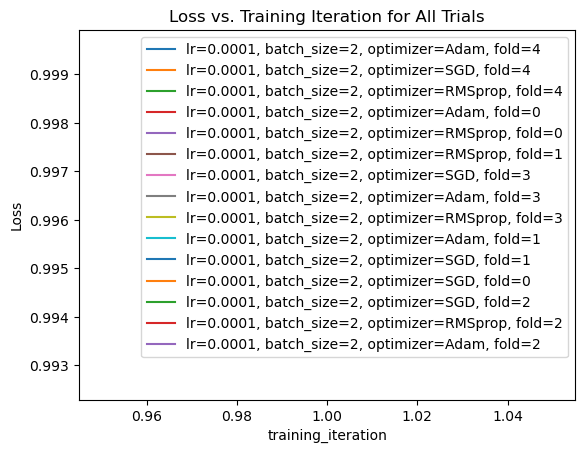

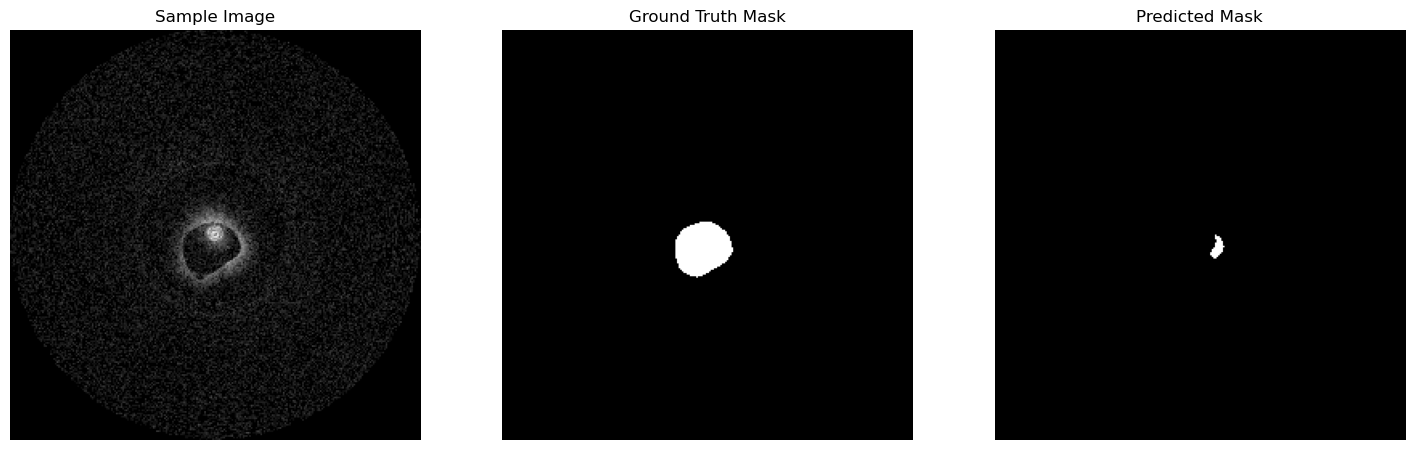

In [ ]:
storage_path = r"C:\Users\johan\ray_results"
exp_name = "train_model_cv_2024-11-23_18-29-42"
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path}...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable=train_model_cv)
result_grid = restored_tuner.get_results()

# Check if there have been errors
if result_grid.errors:
    print("One of the trials failed!")
else:
    print("No errors!")

num_results = len(result_grid)
print("Number of results:", num_results)

# Iterate over results
for i, result in enumerate(result_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(f"Trial #{i} finished successfully with a loss of: {result.metrics['loss']}")

results_df = result_grid.get_dataframe()
results_df[["training_iteration", "loss"]]

print("Shortest training time:", results_df["time_total_s"].min())
print("Longest training time:", results_df["time_total_s"].max())

ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.4f}, batch_size={result.config['batch_size']}, optimizer={result.config['optimizer']}, fold={result.config['fold']}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "loss", ax=ax, label=label)
ax.set_title("Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Loss")

from ray.train import Result

# Get the result with the maximum test set `mean_accuracy`
best_result: Result = result_grid.get_best_result()

print("Best trial config: {}".format(best_result.config))

# Get the best trial's final loss and accuracy
best_loss = best_result.metrics["loss"]
print("Best trial final test set loss: {}".format(best_loss))
best_accuracy = best_result.metrics["accuracy"]
print("Best trial final test set accuracy: {}".format(best_accuracy))

# Load the best model
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

best_trained_model = UnetNoPretraining().to(device)

# Load the best checkpoint
checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

model_state, optimizer_state = torch.load(checkpoint_path, weights_only=True)
best_trained_model.load_state_dict(model_state)

# Set the model to evaluation mode
best_trained_model.eval()

# Load a sample image from the test dataset
root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_gentuity"
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])
test_dataset = OCTDataset(root_dir, transform=transform, train=False, is_gentuity=True)
random_indices = np.random.choice(len(test_dataset), 1, replace=False)
sample_image, sample_mask, _, _ = test_dataset[random_indices[0]]  # Change the index to load a different sample

# Move the sample image to the appropriate device
sample_image = sample_image.to(device).unsqueeze(0)  # Add batch dimension

# Make a prediction
with torch.no_grad():
    prediction = best_trained_model(sample_image)

# Convert the prediction to a binary mask
predicted_mask = (prediction > 0.5).float()

# Plot the sample image, ground truth mask, and predicted mask
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(sample_image.squeeze().permute(1, 2, 0).cpu().numpy())
ax[0].set_title("Sample Image")
ax[0].axis('off')

ax[1].imshow(sample_mask.squeeze().cpu().numpy(), cmap='gray')
ax[1].set_title("Ground Truth Mask")
ax[1].axis('off')

ax[2].imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
ax[2].set_title("Predicted Mask")
ax[2].axis('off')

plt.show()